In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.metrics
import seaborn as sns
import sys
import os
sys.path.append('..')
import util.bq_util

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load up some data

In [3]:
DATASET = "recommendations"
PREDICTION_TABLE = "predictions"
BUCKET = "ka_users/amy/"

In [4]:
bq, gcs = util.bq_util.get_authed_clients()

Authenticating with BigQuery and GCS...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=124072386181-qqedvnl36ver0khc3pmqbh4bevlh58qd.apps.googleusercontent.com&access_type=offline

Enter verification code: 4/QY4ctib7-bkwEYCAuXayy-PCKgW2lKi3OcR-F9HeeOg
Authentication successful.


In [5]:
#bq.tables().list(projectId="khanacademy.org:deductive-jet-827", datasetId=DATASET).execute()

In [6]:
filename = "rec_training000000000000.csv"
util.bq_util.list_files_in_gcs_bucket(gcs, os.path.join(BUCKET, filename))

[u'amy/rec_training000000000000.csv']

In [7]:
util.bq_util.download_files_from_gcs(gcs, os.path.join(BUCKET, filename))
df = pd.read_csv(filename)

## Define preprocessing + modeling functionality

In [8]:
def bow_a_field(userdf, field):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tokenizer = TfidfVectorizer()
    title_text_feats = tokenizer.fit_transform(userdf["title"].values).todense()
    feature_names = tokenizer.get_feature_names()
    d = {}
    for i, feat in enumerate(feature_names):
        d[feat] = [cell[0] for cell in title_text_feats[:,i].tolist()]
    subdf = pd.DataFrame(data=d)
    subdf = subdf.rename(columns={col: field + "_" + col for col in subdf.columns})
    udf = userdf.copy()
    for col in subdf.columns:
        udf[col] = subdf[col].values
    return udf

def feature_processing(userdf):
    """Preprocess dataframe for a single user"""
    DV = ["engaged"] # DV = did they engage with the content
    features = ["kind", 
                "title", 
                "domain", 
                "subject", 
                "topic", 
                #"keywords"
                "tutorial", 
                "num_learners_per_day", 
                "total_score",
                "content_id",
               ]
    data = userdf[DV + features].dropna()
    for field in ["title"]:
        data = bow_a_field(data, field)
    return data

def split_data(data): 
    """Split data into X, Y"""
    Y = data["engaged"]
    content_ids = data["content_id"].values
    features = data[[col for col in data.columns if col not in ("engaged", "content_id")]]
    # dummify anything still in categorical form
    X = pd.get_dummies(features)
    return X, Y, content_ids

def train_and_evaluate(X_feats, Y_feats, clf, print_it=False):
    """Run cross-validation for crude model evaluation."""
    X = X_feats.values
    Y = Y_feats.values
    kf = sklearn.cross_validation.StratifiedKFold(Y, n_folds=2, shuffle=True, random_state=100)
    for i, (train_index, test_index) in enumerate(kf):
        if print_it:
            print "WORKING ON FOLD %s:" %i
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        predicted = clf.predict(X_test)
        probabilities = [p[1] for p in clf.predict_proba(X_test)]
        print_metrics(Y_test, predicted, probabilities, print_it=print_it)
    return Y_test, predicted, probabilities

def print_metrics(true, predicted, proba, print_it=False):
    """For debugging/investigating individual user metrics."""
    auc = sklearn.metrics.roc_auc_score(true, proba)
    accuracy = sklearn.metrics.accuracy_score(true, predicted)
    f1 = sklearn.metrics.f1_score(true, predicted)
    recall = sklearn.metrics.recall_score(true, predicted)
    precision = sklearn.metrics.precision_score(true, predicted)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, proba)
    if print_it:
        print "accuracy: %s" % accuracy
        print "auc: %s" % auc
        print "f1: %s" % f1
        print "recall: %s" % recall
        print "precision: %s" % precision
        
def final_predict(kaid, userdf, clf):
    # split into positive and negative examples (all positive examples will go in training data)
    positives = userdf[userdf["engaged"]==1]
    negatives = userdf[userdf["engaged"]==0]
    
    # split remaining negatives into training and test (top half most popular will be test)
    train = negatives[:len(negatives)/2]
    test_ids = negatives[len(negatives)/2:].content_id.values
    train_ids = pd.concat([train, positives]).content_id.values
    prepped_data = feature_processing(userdf)
    
    #Split into X and Y + construct training and tests sets
    X, Y, cids = split_data(prepped_data)
    X_train, Y_train = [], []
    X_test, Y_test, test_cids = [], [], []
    for i, content_id in enumerate(cids):
        if content_id in train_ids:
            X_train.append(X.values[i])
            Y_train.append(Y.values[i])
        elif content_id in test_ids:
            X_test.append(X.values[i])
            Y_test.append(Y.values[i])
            test_cids.append(content_id)
            
    # fit model and make predictions
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    probas = [p[1] for p in clf.predict_proba(X_test)]
    
    # construct result structures for storing and using the data
    df = pd.DataFrame(data={
            "prediction": predictions,
            "probability": probas,
            "content_id": test_cids
        })
    r = pd.merge(df, userdf[["content_id", "node_slug", "total_score", "kind", "domain", "subject"]], how="inner")
    r["pscore"] = r["probability"]**.5
    r["general_zscore"] = (r["total_score"] - r["total_score"].min())/(r["total_score"].max() - r["total_score"].min())
    r["score"] = (r["pscore"] + r["general_zscore"])/2
    r = r.sort("score", ascending=False)
    r["kaid"] = [kaid for i in range(len(r))]
    return r

def update_user_summary(userdf, kaid, true, prob, summary):
    """Update the table of single user summary stats."""
    summary["auc"].append(sklearn.metrics.roc_auc_score(true, prob))
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, prob)
    summary["num_positive"].append(userdf.engaged.sum())
    summary["kaid"].append(kaid)
    summary["joined"].append(userdf.joined.max())
    summary["fpr"].append(fpr)
    summary["tpr"].append(tpr)
    return summary

def update_validation(kaid, true, pred, prob, validation):
    """Update the table of full truth vs. prediction stats"""
    validation["true"].extend(true)
    validation["predicted"].extend(pred)
    validation["probability"].extend(prob)
    validation["kaid"].extend([kaid for i in true])
    return validation

def classification_pipeline(df, top_n=100):
    """Run a the full classification pipeline to generate data for model evaluation, 
       and predictions for the recommender system."""
    
    # initialize resulting table data
    results = []
    validation = {"true":[], "predicted":[], "probability": [], "kaid":[]}
    summary = {"auc":[], "num_positive": [], "kaid": [], "joined": [], "fpr":[], "tpr":[]}
    
    # train, evaluate, and predict for each user individually
    for kaid in df.kaid.unique():
        userdf = df[df["kaid"]==kaid]
        if userdf["engaged"].sum() <= 2:
            print "Skipping %s" % kaid
            continue
        print "Running %s" % kaid
        # preprocess data
        prepped_data = feature_processing(userdf)
        # train and evaluate model
        X, Y, _ = split_data(prepped_data)
        clf = sklearn.linear_model.LogisticRegression()
        true, pred, prob = train_and_evaluate(X, Y, clf)
        summary = update_user_summary(userdf, kaid, true, prob, summary)
        validation = update_validation(kaid, true, pred, prob, validation)
        # train full model + generate predictions
        clf = sklearn.linear_model.LogisticRegression()
        r = final_predict(kaid, userdf, clf)
        results.append(r[:top_n])
        
    # construct final pandas dataframes
    final_df = pd.concat(results)
    validation_df = pd.DataFrame(data=validation)
    summary_df = pd.DataFrame(data=summary)
    return final_df, validation_df, summary_df

## Train + Evaluate

In [9]:
final_df, validation_df, summary_df = classification_pipeline(df)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:114: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Skipping kaid_322962904607449063775472
Running kaid_615122688051978532432289
Running kaid_254884632901887636749179
Skipping kaid_972312616504392465407997
Running kaid_1021816025188633856726110
Running kaid_177300951159445504653755
Skipping kaid_19374345126826952044339
Running kaid_407089334193359735364153
Running kaid_1118218441556727937149064
Skipping kaid_556022798793514927715493
Skipping kaid_73776605891154008780640
Running kaid_175634518858381301723625
Running kaid_1055056106831724695622524
Running kaid_447317448596630962092364
Running kaid_226668233168615918510403
Running kaid_126074402873291901558842
Running kaid_694790541833528675386594
Skipping kaid_1127696500567694409297156
Running kaid_13656233299547006357001
Skipping kaid_244119897602537658027200
Running kaid_889915840622529423015409
Running kaid_533239023227152353322535
Running kaid_1026042980439454106016074
Skipping kaid_325374501095247410801428
Running kaid_456480905066980070292764
Skipping kaid_192151328833642449115110
S

In [11]:
final_df.head()

,content_id,prediction,probability,node_slug,total_score,kind,domain,subject,pscore,general_zscore,score,kaid
683,x7aa228af,1,0.701305,v/programming-intro,48.840667,Video,computing,computer-programming,0.837439,1.000000,0.918720,kaid_615122688051978532432289
768,2600769,0,0.132428,v/adding-fractions-with-unlike-denominators,31.792000,Video,math,fr-seventh-grade-math,0.363907,0.636541,0.500224,kaid_615122688051978532432289
397,2600759,0,0.083351,v/multiplying-fractions,27.366000,Video,math,arithmetic,0.288707,0.542183,0.415445,kaid_615122688051978532432289
578,183171788,0,0.045065,v/elements-and-atoms,23.590667,Video,science,chemistry,0.212285,0.461697,0.336991,kaid_615122688051978532432289
67,19647488,0,0.060904,v/negative-numbers-introduction,21.036000,Video,math,pre-algebra,0.246786,0.407234,0.327010,kaid_615122688051978532432289


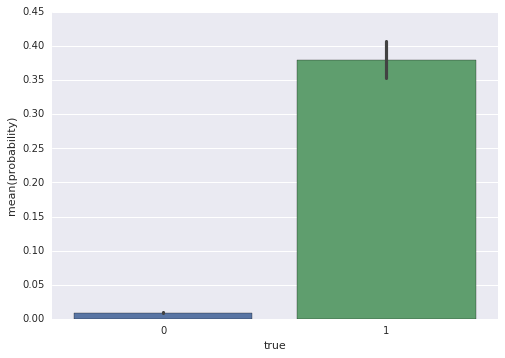

In [12]:
sns.barplot(x="true", y="probability", data=validation_df)

In [13]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(validation_df["true"], validation_df["probability"])
print sklearn.metrics.roc_auc_score(validation_df["true"], validation_df["probability"])

0.908931509196


(-0.02, 1.02)

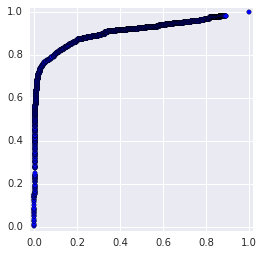

In [14]:
f,ax = plt.subplots(figsize=[4,4])
plt.scatter(fpr, tpr)
plt.ylim([-.02,1.02])
plt.xlim([-.02,1.02])

In [15]:
m = summary_df.auc.mean()
se = summary_df.auc.std(dof=0)/np.sqrt(len(summary_df))
#plt.bar([0], [m], yerr=[se])
print m, se

0.748034777528 0.0320353802486


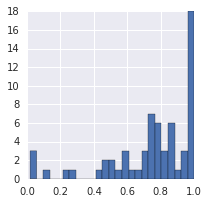

In [16]:
summary_df.auc.hist(bins=25, figsize=[3,3])

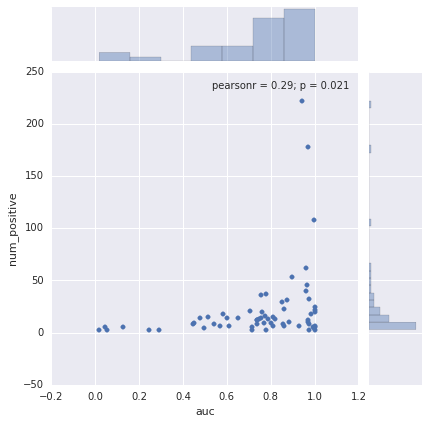

In [17]:
sns.jointplot("auc", "num_positive", summary_df)

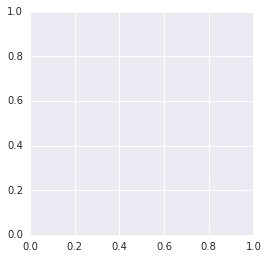

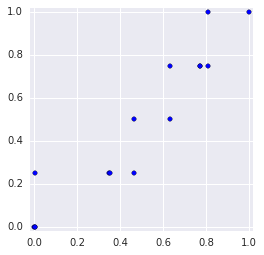

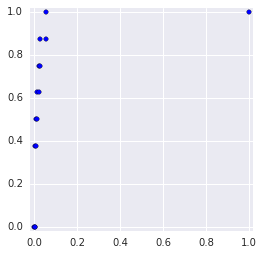

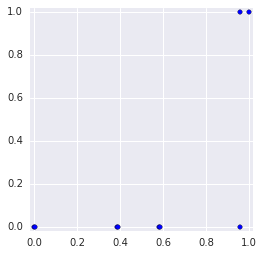

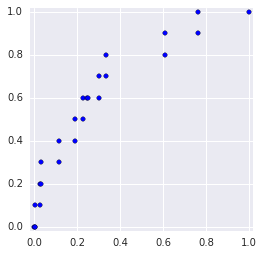

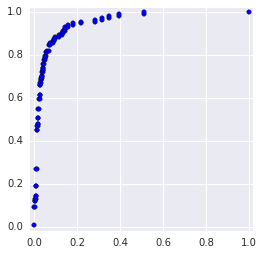

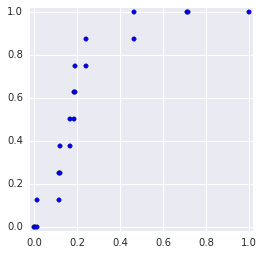

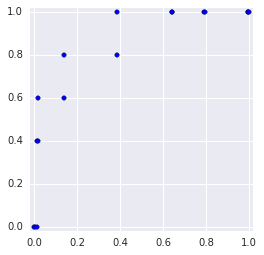

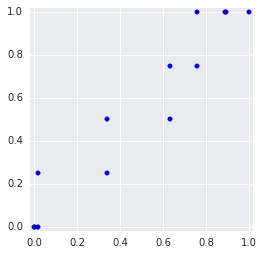

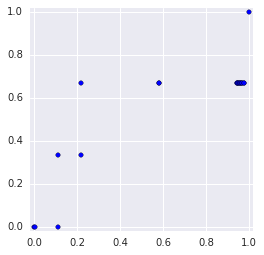

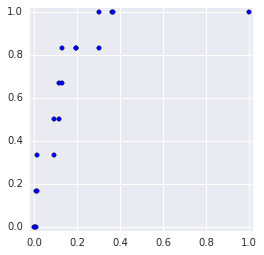

In [18]:
f, ax = plt.subplots(figsize=[4,4])
for i, row in summary_df[:10].iterrows():
    f, ax = plt.subplots(figsize=[4,4])
    plt.scatter(row["fpr"], row["tpr"])
    plt.ylim([-.02,1.02])
    plt.xlim([-.02,1.02])

## Save predictions back to BigQuery

for kaid in final_df.kaid.unique():
    print kaid
    print final_df[final_df["kaid"]==kaid][:10]["node_slug"].values

In [12]:
variables = ["kaid", "kind", "content_id", "node_slug", "domain", "subject", "probability", "prediction", "score"]
predictions_to_save = final_df[variables]

In [13]:
import util.secrets
util.bq_util.upload_df_to_bq(bq, predictions_to_save, util.secrets.BIGQUERY_PROJECT_ID, DATASET, PREDICTION_TABLE, 1000)

Streaming Insert is 15% Complete


KeyboardInterrupt: 

In [28]:
reload(util.bq_util)

SyntaxError: invalid syntax (bq_util.py, line 96)